In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime
from numpy import array
from numpy import hstack

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
import matplotlib.pyplot as plt

%matplotlib inline
np. set_printoptions(suppress=True)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [2]:
positions = ['QB','RB','WR','TE']
qb = q = 'QB'
rb = r = 'RB'
wr = w = 'WR'
te = t = 'TE'

cols = ['player_name','pos','posteam','defteam','game_id','game_date','season','week','fanPts']

df = {}
d = {}
for pos in positions:
    df[pos] = pd.read_csv(f'data/clean/{pos}.csv')
    d[pos] = df[pos][cols].groupby(['player_name','season','week','game_date','defteam']).sum().reset_index().set_index(['season','week'])

In [3]:
ref = {}
for team in d[pos].defteam.unique():
    ref[team] = {}
    for pos in positions:
        ref[team][pos] = d[pos][d[pos].defteam==team].groupby(['season','week']).sum().rename(columns={'fanPts':pos})

allowed = {}
for team in ref.keys():
    allowed[team] = pd.DataFrame(index=pd.MultiIndex(levels=[[],[]],codes=[[],[]],names=['season','week']))
    for pos in positions:
        allowed[team] = allowed[team].join(ref[team][pos], how='outer')
    allowed[team] = allowed[team]

In [4]:
def get(name, exact=False):
    names = {}
    for pos in positions:
        if exact:
            names[pos] = d[pos][d[pos].player_name==name].player_name.unique()
        else:
            names[pos] = d[pos][d[pos].player_name.str.lower().str.contains(name.lower())].player_name.unique()
        if len(names[pos]) > 0:
            print(f'{pos}: {names[pos]}')
    
    if sum([len(names[pos]) for pos in positions]) == 1:
        pos = positions[[len(names[pos]) for pos in positions].index(1)]
        out = d[pos][d[pos].player_name==names[pos][0]].sort_values(['season','week'])
        
        # Add in allowed series for each row
        for team in ref.keys():
            add = allowed[team].copy()[[pos]]
            add.columns = add.columns.map(lambda x: f'{team}')#_' + str(x))
            out = out.join(add,how='left')
        
        return out
    elif not exact:
        return get(name, True)
    else:
        print('No unique matches found.')

In [12]:
# split a multivariate sequence into samples
def split_sequences(dataset, n_steps, data):
    X, y = list(), list()
    for i in range(len(dataset)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(dataset)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix,:], dataset[end_ix,:]
        
        # Process opponent allowed series
        opp = seq_y[2]
        seq_x = seq_x[:,[3,list(data.columns).index(opp)]].astype(float)
        seq_y = seq_y[[3,list(data.columns).index(opp)]].astype(float)
        
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X),array(y)

In [ ]:
def run(player):
    # PREP
    data = get(player)
    data['target'] = data.fanPts

    data['target'].plot()
    plt.show()
    
    input_steps = 16
    test_steps = 16

    train = data[:-input_steps]
    test = data[-test_steps:]

    seqs = []
    for col in data.columns:
        seq = train[col].values
        seq = seq.reshape((len(seq), 1))
        seqs.append(seq)

    dataset = hstack(seqs)

    X, y = split_sequences(dataset, input_steps, data)
    X[:,:,1] = np.nan_to_num(X[:,:,1], nan=np.nanmean(X[:,:,1])) #de-NaN

    n_features = X.shape[2]
    
    # TRAIN
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(input_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) #TODO: Focus loss only on target variable

    history =  model.fit(X, y, epochs=12, validation_split=.2, verbose=1)
    
    # EVAL
    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # TEST
    test_input = array(train[-input_steps:])
    test_input = test_input.reshape((1, input_steps, len(train.columns)))[:,-input_steps:,3]
    test_actual = array(test)
    test_actual = test_actual.reshape((1, test_steps, len(test.columns)))

    defProj = train.iloc[-input_steps:,3:-1]
    for i in range(test_steps):
        defProj = defProj.append(np.mean(defProj[-test_steps:]),ignore_index=True)

    for i in range(test_input.shape[1]):
        opp = test_actual[0,i,2]

        test_fanPts = test_input[:,-input_steps:]
        test_defProj = defProj.iloc[i:i+16,defProj.columns.get_loc(opp)]
        seq = np.vstack((test_fanPts,test_defProj)).T.astype(float).reshape(1,input_steps,n_features)

        seq[0,:,1] = np.nan_to_num(seq[0,:,1], nan=np.nanmean(seq[0,:,1])) #de-NaN

        yhat = model.predict(seq)
        test_input = np.append(test_input, yhat, axis=1)    
        pred = test_input[0,-test_steps:]
    
    #Plot results
    x = np.arange(len(data.fanPts)-test_steps, len(data.fanPts), 1)

    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(data.reset_index().fanPts)
    plt.plot(x,pred)
    plt.legend(('Actual', 'Predicted'))
    plt.show()

    #Zoom plot
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)

    x1 = [datetime.datetime.strptime(x,'%Y-%M-%d').strftime('%-m/%-d/%y') for x in data.game_date[-test_steps:]]
    plt.plot(x1,data.reset_index().fanPts[-test_steps:])
    plt.plot(x1,pred)
    plt.legend(('Actual', 'Predicted'))
    plt.show()
    
    return history

QB: ['A.Rodgers']


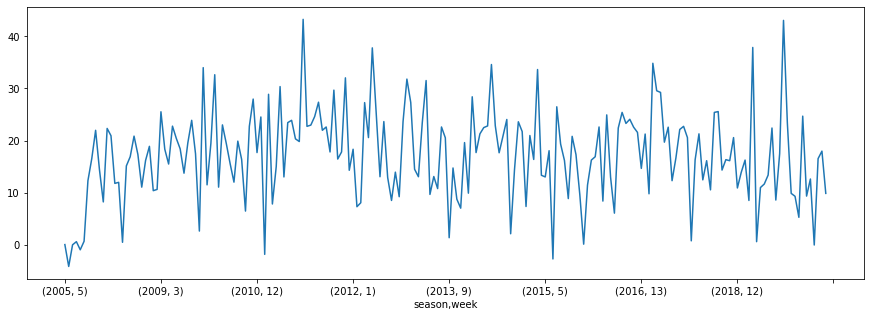

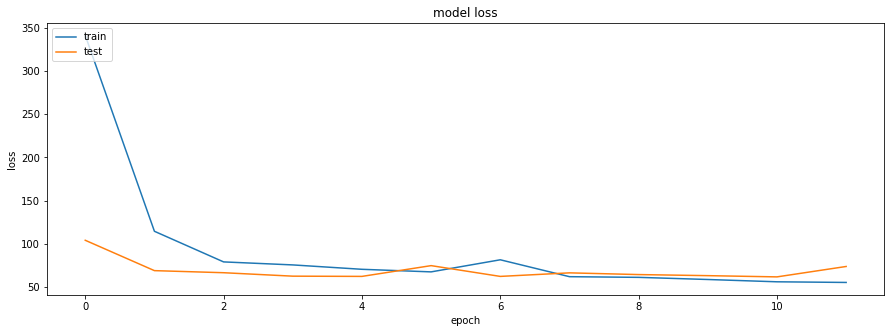

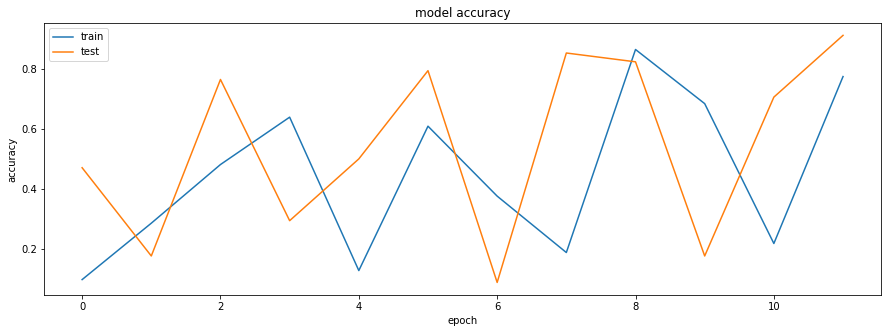

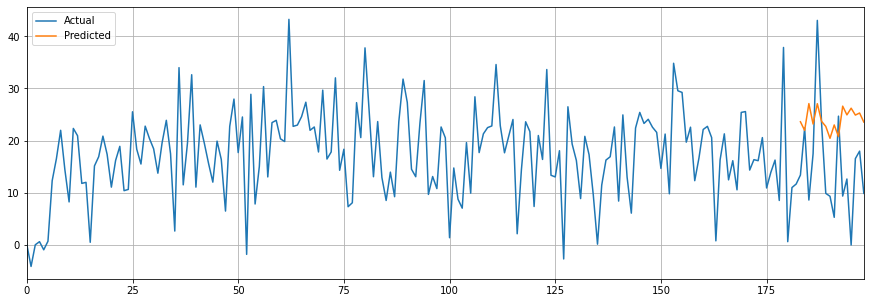

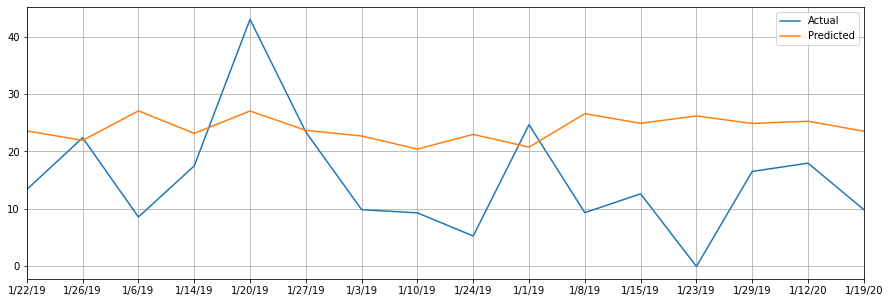

In [15]:
history = run('a.rodgers')